# Social Engineering Scam Detector baseline

Based on PHISHING EMAIL AND SPAM SMS AI DETECTION TOOL by Konstantinos Zafeiropoulos from Kaggle
https://www.kaggle.com/code/zafko8/phishing-email-and-spam-sms-ai-detection-tool

https://arxiv.org/pdf/2405.11619

[Submitted on 19 May 2024]
Novel Interpretable and Robust Web-based AI Platform for Phishing Email Detection

Abdulla Al-Subaiey, Mohammed Al-Thani, Naser Abdullah Alam, Kaniz Fatema Antora, Amith Khandakar, SM Ashfaq Uz Zaman

In [1]:
import os 
os.getcwd()

'/Users/VyasSrinivasan/AI-Social-Engineering-Scam-Detector'

In [2]:
import sys
!{sys.executable} -m pip install shap

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


#### Import libraries

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/VyasSrinivasan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load datasets

In [5]:
print("Files in Current Directory:", os.listdir(os.getcwd()))

Files in Current Directory: ['.DS_Store', 'models', '.ipynb_checkpoints', 'social_engineering_scam_detector_baseline.ipynb', 'data', 'notebooks']


In [6]:
#Email
df_email = pd.read_csv("./data/email.csv")
df_email.columns = ["Category", "Message"]

#SMS
df_smsText = pd.read_csv("./data/Spam_SMS.csv")
df_smsText.columns = ["Category", "Message"]

#UCI SMS
df_uciSmsText = pd.read_csv("./data/SMSSpamCollection", sep="\t", header=None, names=["Category", "Message"])


In [7]:
df_email.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df_smsText.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df_uciSmsText.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
phishingFiles = ["CEAS_08", "Enron", "Ling", "Nazario", "Nigerian_Fraud", "phishing_email", "SpamAssasin"]

In [11]:
phishDF = []
for phishFile in phishingFiles:
    try:
        df_temp = pd.read_csv("./data/Phishing/" + phishFile + ".csv")
        df_temp = df_temp.iloc[:, :2]
        df_temp.columns = ["Category", "Message"]
        phishDF.append(df_temp)
        
    except Exception as e:
        print("Error loading ./data/Phishing/"+phishFile+ ".csv : " + e)
        

In [12]:
#Combine the datasets
df = pd.concat([df_smsText, df_email, df_uciSmsText] + phishDF, ignore_index=True)
df.dropna(subset=["Category", "Message"], inplace=True)

In [13]:
# Clean and encode labels
df["Category"] = df["Category"].astype(str).str.lower().str.strip()
df = df[df["Category"].isin(["spam", "ham"])]
df["Category"] = df["Category"].map({"spam": 0, "ham": 1})
df.dropna(inplace=True)

print(f"Total Samples Before Balancing: {df.shape[0]}")

Total Samples Before Balancing: 16718


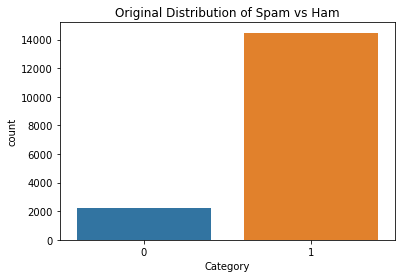

In [14]:
# Visualize original distribution
sns.countplot(data=df, x="Category")
plt.title("Original Distribution of Spam vs Ham")
plt.show()

In [15]:
# Balance the dataset (undersampling)
spam_df = df[df["Category"] == 0]
ham_df = df[df["Category"] == 1].sample(len(spam_df), random_state=42)
df_balanced = pd.concat([spam_df, ham_df]).sample(frac=1, random_state=42)

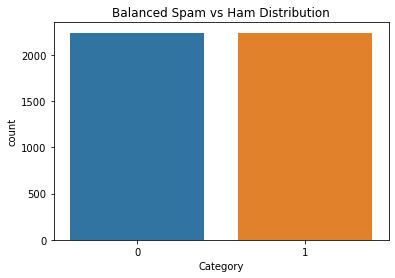

In [16]:
# Visualize balanced data
sns.countplot(data=df_balanced, x="Category")
plt.title("Balanced Spam vs Ham Distribution")
plt.show()

In [17]:
# Train/test split on balanced data
X = df_balanced["Message"]
Y = df_balanced["Category"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

In [18]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(min_df=1, stop_words="english", lowercase=True)
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

In [19]:
# Train model
model = LogisticRegression()
model.fit(X_train_features, Y_train)

LogisticRegression()

In [20]:
# Evaluate model
train_pred = model.predict(X_train_features)
test_pred = model.predict(X_test_features)

In [21]:
print("Accuracy on training data:", accuracy_score(Y_train, train_pred))
print("Accuracy on testing data:", accuracy_score(Y_test, test_pred))

📈 Accuracy on training data: 0.9896792189679219
📊 Accuracy on testing data: 0.9743589743589743


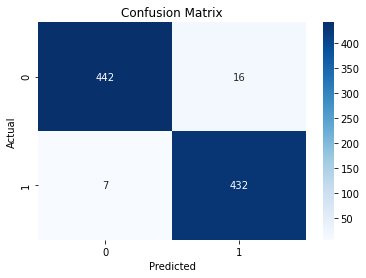

In [22]:
# Confusion matrix
cm = confusion_matrix(Y_test, test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [23]:
# Test the model
new_messages = ["Congratulations! You have won a free ticket to Bahamas! Click here.",
                "Hey are we still on for lunch today?"]
new_features = vectorizer.transform(new_messages)
predictions = model.predict(new_features)

for msg, pred in zip(new_messages, predictions):
    label = "Ham" if pred == 1 else "Spam"
    print(f"Message: {msg}\nPrediction: {label}\n")

Message: Congratulations! You have won a free ticket to Bahamas! Click here.
Prediction: Spam

Message: Hey are we still on for lunch today?
Prediction: Ham



In [24]:
import time

def predict_message(msg):
    features = vectorizer.transform([msg])
    
    start_time = time.time()  # Start timer
    result = model.predict(features)[0]
    end_time = time.time()    # End timer

    label = "Ham" if result == 1 else "Spam"
    duration = (end_time - start_time) * 1000  # in milliseconds
    print(f"Message: {msg}")
    print(f"Prediction: {label}")
    print(f"Prediction Time: {duration:.4f} ms")


In [25]:
user_msg = input("Enter a message to check: ")
predict_message(user_msg)

Enter a message to check: Congratulations! You have won a free ticket to Bahamas! Click here.",                 "Hey are we still on for lunch today?
Message: Congratulations! You have won a free ticket to Bahamas! Click here.",                 "Hey are we still on for lunch today?
Prediction: Ham
Prediction Time: 0.5388 ms


In [26]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, test_pred, target_names=["Spam", "Ham"]))

              precision    recall  f1-score   support

        Spam       0.98      0.97      0.97       458
         Ham       0.96      0.98      0.97       439

    accuracy                           0.97       897
   macro avg       0.97      0.97      0.97       897
weighted avg       0.97      0.97      0.97       897



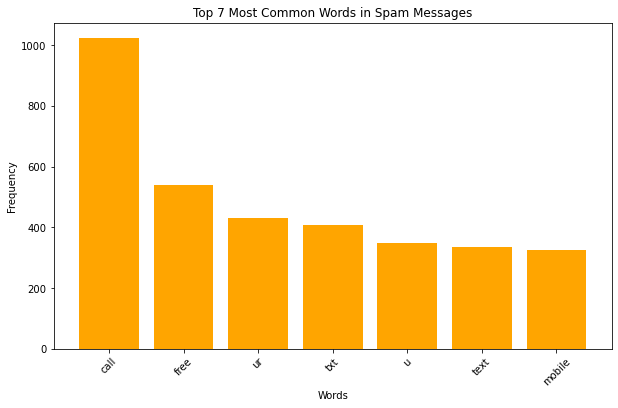

In [27]:
# Most common spam words
stop_words = set(stopwords.words("english"))
spam_words = " ".join(df[df['Category'] == 0]['Message']).split()
word_freq = Counter([word.lower() for word in spam_words if word.lower() not in stop_words and word.isalpha()])

plt.figure(figsize=(10, 6))
plt.bar(*zip(*word_freq.most_common(7)), color='orange')
plt.title("Top 7 Most Common Words in Spam Messages")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [28]:
#Explainability, Reducing AI Risks

import shap

# Convert sparse matrix to dense
X_sample_dense = X_test_features[:5].toarray()

# Use LinearExplainer for LogisticRegression
explainer = shap.Explainer(model, X_train_features[:100].toarray())  # small background for performance
shap_values = explainer(X_sample_dense)

             Word  Mean SHAP Value
5435          www         0.260129
4866         text         0.201251
4655         stop         0.200190
3559           ok         0.194533
5067          txt         0.132832
2256         free         0.130302
3324       mobile         0.127126
3488        nokia         0.123162
5090           uk         0.118455
5143           ur         0.114875
4984         tone         0.113532
5318         week         0.095636
2535         help         0.095324
1743         dear         0.094910
1576        comuk         0.079369
5128  unsubscribe         0.075340
3786          pls         0.068291
4884        thanx         0.064694
4344     services         0.060560
353            16         0.059501


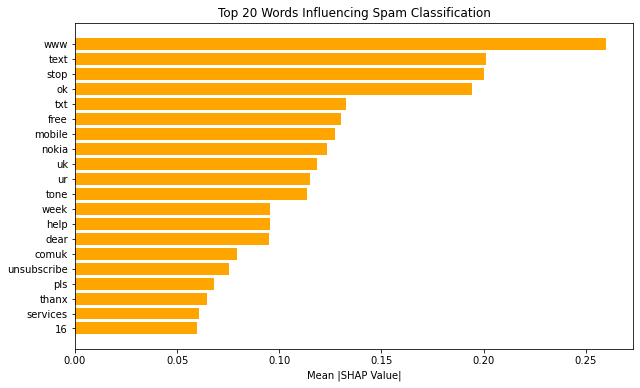

In [29]:
# Get TF-IDF feature names
feature_names = vectorizer.get_feature_names()

# Get mean absolute SHAP values
import numpy as np
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create DataFrame mapping feature indices to words
import pandas as pd
shap_df = pd.DataFrame({
    'Word': feature_names,
    'Mean SHAP Value': mean_shap_values
})

# Sort and display top 20 most influential words
shap_df_sorted = shap_df.sort_values(by='Mean SHAP Value', ascending=False).head(20)
print(shap_df_sorted)

# Plot top SHAP words
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(shap_df_sorted['Word'], shap_df_sorted['Mean SHAP Value'], color='orange')
plt.xlabel("Mean |SHAP Value|")
plt.title("Top 20 Words Influencing Spam Classification")
plt.gca().invert_yaxis()
plt.show()

In [30]:
def test_real_email():
    import time

    # Ask user to paste their email
    print("Paste the full email content below (e.g., subject + body):\n")
    email_text = input("Email: ")

    # Transform with vectorizer
    features = vectorizer.transform([email_text])

    # Predict
    start_time = time.time()
    result = model.predict(features)[0]
    end_time = time.time()

    # Interpret result
    label = "Ham (Safe Message)" if result == 1 else "Spam/Phishing"
    print("\nEmail Content Preview:")
    print("-" * 60)
    print(email_text[:300] + ("..." if len(email_text) > 300 else ""))
    print("-" * 60)
    print(f"Prediction: {label}")
    print(f"Prediction Time: {(end_time - start_time)*1000:.2f} ms")

In [31]:
# Call this to test
test_real_email()

Paste the full email content below (e.g., subject + body):

✉️ Email: Get Outlook for iOS -- Good Morning  Vyas Please share your direct mobile contact with me as soon as possible? Kindly email it promptly.  Thank you

Email Content Preview:
------------------------------------------------------------
Get Outlook for iOS -- Good Morning  Vyas Please share your direct mobile contact with me as soon as possible? Kindly email it promptly.  Thank you
------------------------------------------------------------
Prediction: Ham (Safe Message)
Prediction Time: 0.37 ms
